# PyTorch Perceptron 예제

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# 선형 분리가 가능한 간단한 데이터셋 (AND 게이트)
inputs = torch.tensor([[0., 0.],
                       [0., 1.],
                       [1., 0.],
                       [1., 1.]], dtype=torch.float32)
labels = torch.tensor([[0.],
                       [0.],
                       [0.],
                       [1.]], dtype=torch.float32)

class Perceptron(nn.Module):
    def __init__(self):
        super().__init__()
        # 입력 2차원을 하나의 로짓으로 바로 투영하는 단층 퍼셉트론
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        # 시그모이드로 확률처럼 해석 가능한 출력을 만든다
        return torch.sigmoid(self.fc(x))

model = Perceptron()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
# 시각화를 위해 손실과 정확도를 기록
losses = []
accuracies = []

for epoch in range(200):
    optimizer.zero_grad()            # 1) 이전 스텝에서 남은 기울기 초기화
    outputs = model(inputs)          # 2) 순전파로 현재 예측 계산
    loss = criterion(outputs, labels)  # 3) BCE 손실 계산
    loss.backward()                  # 4) 가중치별 기울기 역전파
    optimizer.step()                 # 5) SGD로 파라미터 갱신

    # 손실 스칼라 값을 저장해 나중에 수렴 곡선을 그린다
    losses.append(loss.item())
    with torch.no_grad():
        # 시그모이드 출력을 0/1로 변환해 정확도를 계산
        epoch_preds = (outputs > 0.5).float()
        acc = epoch_preds.eq(labels).float().mean().item()
        accuracies.append(acc)

with torch.no_grad():
    # 학습 루프 종료 후 최종 예측과 손실을 빠르게 확인
    preds = (model(inputs) > 0.5).float()
    print('예측 결과:', preds.squeeze().tolist())
    print('최종 손실:', loss.item())

예측 결과: [0.0, 0.0, 0.0, 1.0]
최종 손실: 0.346233606338501


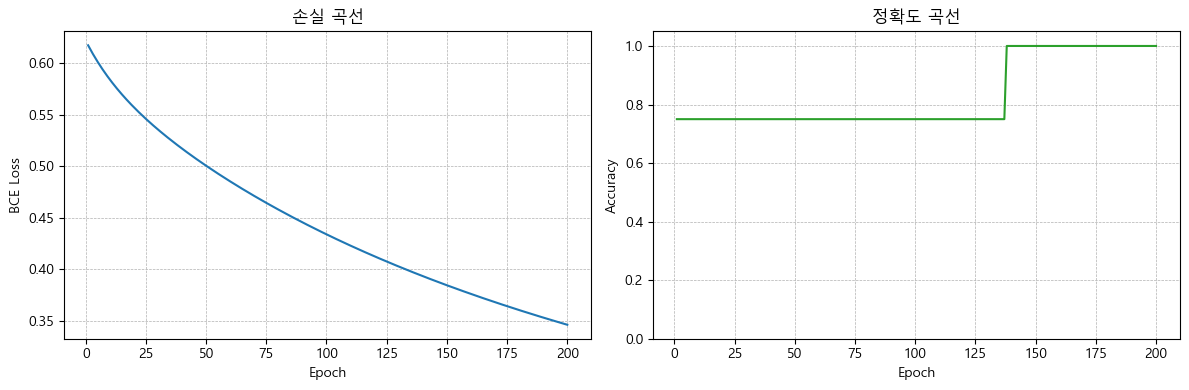

Confusion Matrix:
 [[3 0]
 [0 1]]


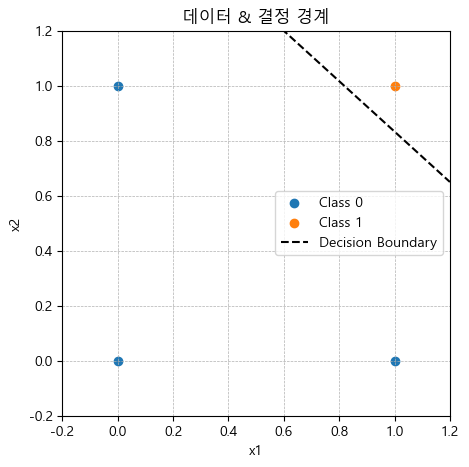

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import font_manager, rcParams


def _configure_korean_font():
    """사용 가능한 한글 폰트를 찾아 Matplotlib에 적용한다."""
    candidates = [
        'Malgun Gothic',
        'AppleGothic',
        'NanumGothic',
        'Noto Sans CJK KR',
        'Noto Sans KR',
        'Noto Sans CJK',
        'NanumBarunGothic',
        'Gulim',
        'Dotum',
        'Batang',
    ]
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in available:
            rcParams['font.family'] = [name]
            rcParams['axes.unicode_minus'] = False
            return name
    rcParams['axes.unicode_minus'] = False
    return None


# 한글 그래프 제목이 깨지지 않도록 폰트를 설정
_configure_korean_font()

# 학습 셀에서 기록한 손실/정확도 이력을 재사용
epochs = range(1, len(losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(epochs, losses, color='tab:blue')
axes[0].set_title('손실 곡선')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[0].grid(True, linestyle='--', linewidth=0.5)

axes[1].plot(epochs, accuracies, color='tab:green')
axes[1].set_title('정확도 곡선')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

with torch.no_grad():
    logits = model(inputs)
    preds_binary = (logits > 0.5).int()
    truth = labels.int()

# 추가 의존성 없이 혼동 행렬을 직접 계산
cm = torch.zeros(2, 2, dtype=torch.int32)
for t, p in zip(truth, preds_binary):
    cm[t.item(), p.item()] += 1

print('Confusion Matrix:\n', cm.numpy())

# 데이터와 학습된 결정 경계를 함께 시각화
fig, ax = plt.subplots(figsize=(5, 5))
data = inputs.numpy()
labels_np = labels.numpy().ravel()
ax.scatter(data[labels_np == 0][:, 0], data[labels_np == 0][:, 1], c='tab:blue', label='Class 0')
ax.scatter(data[labels_np == 1][:, 0], data[labels_np == 1][:, 1], c='tab:orange', label='Class 1')

with torch.no_grad():
    w = model.fc.weight.squeeze().numpy()
    b = model.fc.bias.item()

if abs(w[1]) > 1e-6:
    # 기울기가 존재하면 y = mx + b 꼴의 선을 그린다
    x_vals = np.linspace(-0.2, 1.2, 100)
    y_vals = -(w[0] * x_vals + b) / w[1]
    ax.plot(x_vals, y_vals, color='black', linestyle='--', label='Decision Boundary')
else:
    # 기울기가 무한대로 발산할 때는 수직선을 사용
    x_boundary = -b / w[0]
    ax.axvline(x_boundary, color='black', linestyle='--', label='Decision Boundary')

ax.set_title('데이터 & 결정 경계')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.2)
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5)
plt.show()